In [5]:
from pandas import read_csv
from pandas import read_table
import pandas as pd
import numpy as np
import scipy.sparse
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

# Загрузка данных 

sales_data = read_csv('/home/jose/data_science_test/sales.csv', ';', decimal = ',')

media_data = read_table('/home/jose/data_science_test/media.csv', ';', decimal = ',')

Populating the interactive namespace from numpy and matplotlib


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2dc7d36d8>,
      dtype=object)

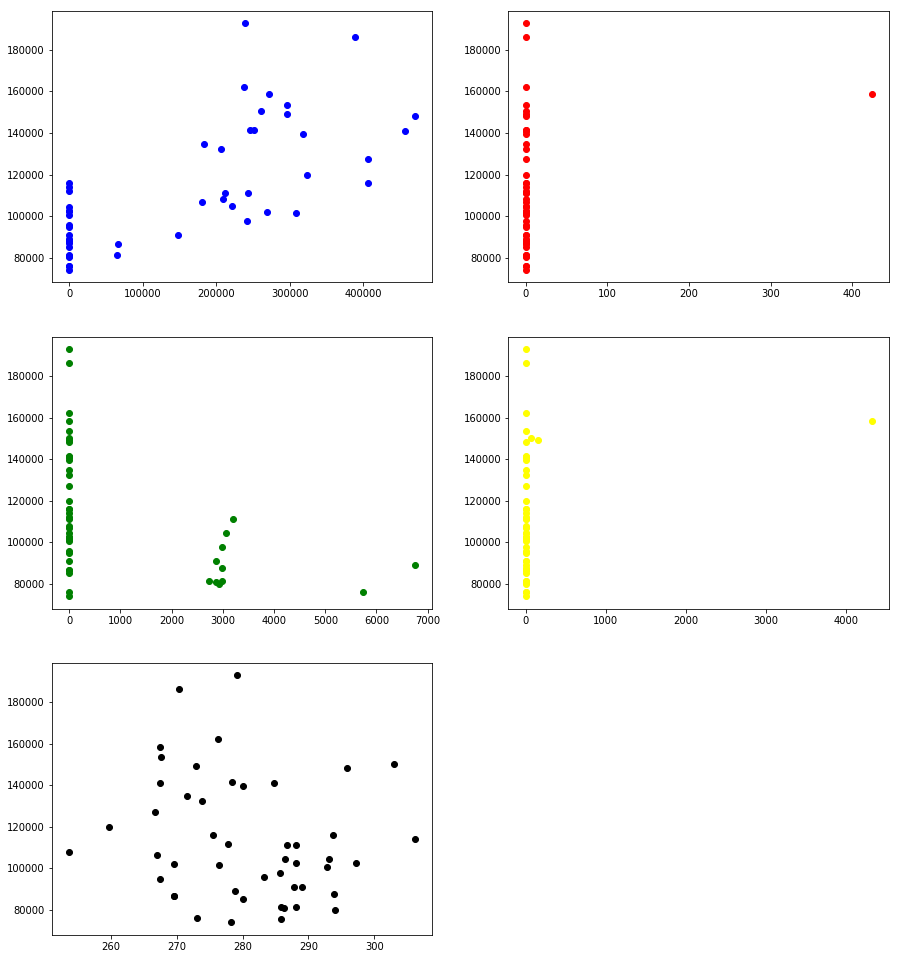

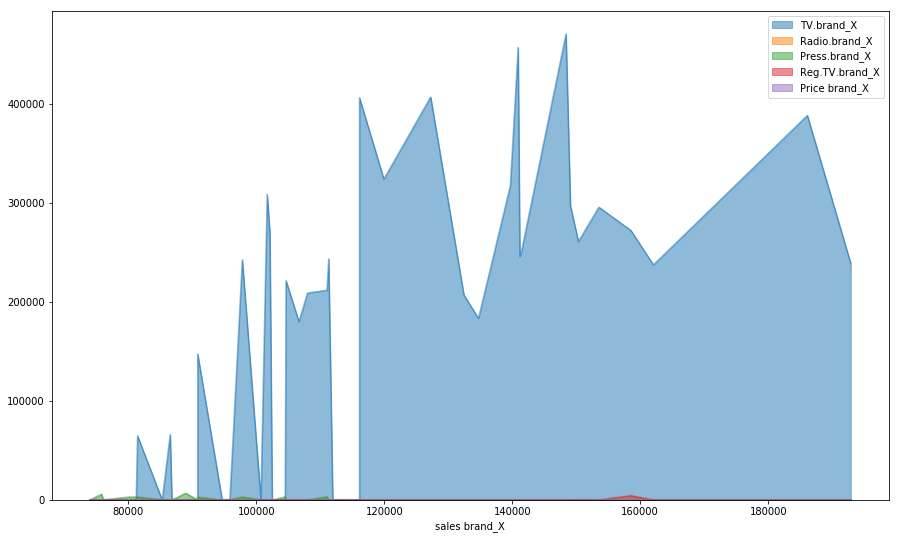

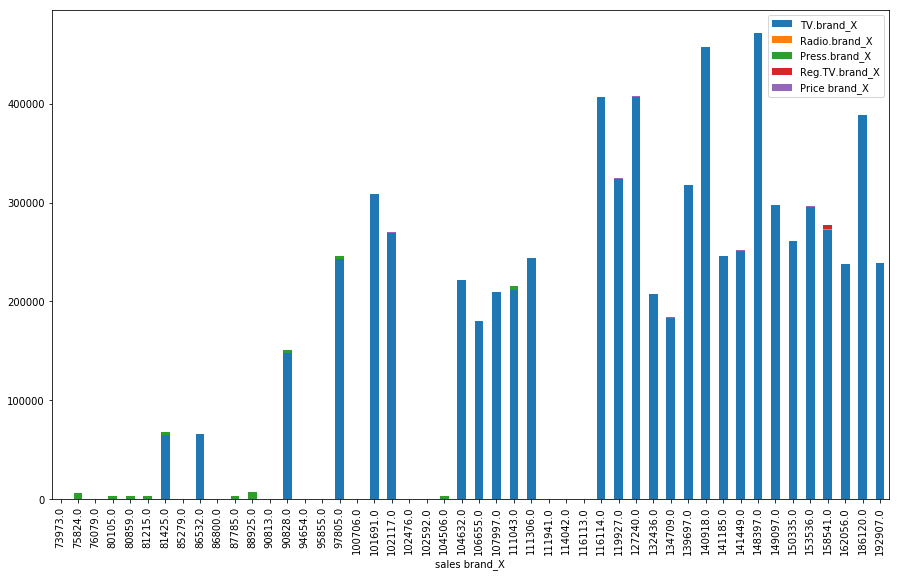

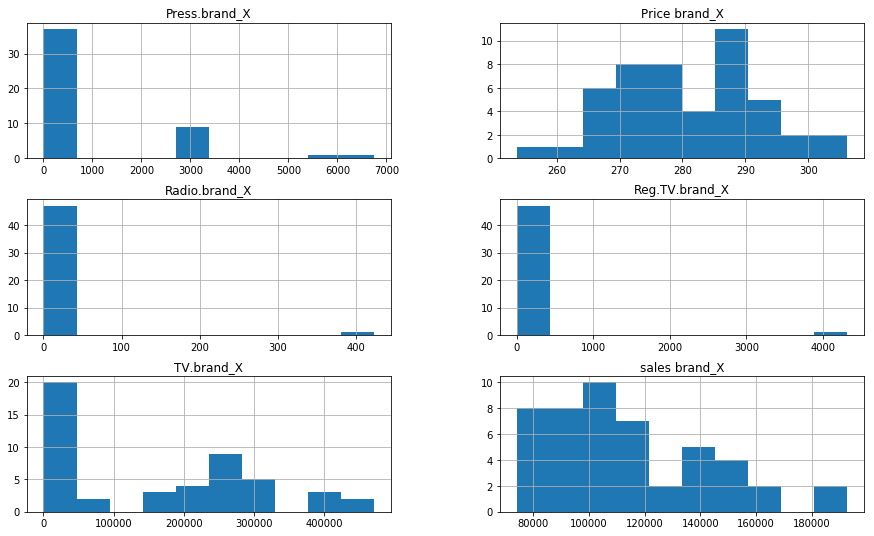

In [6]:
'''Тут для удобства я собираю данные по brand_X в отдельный датафрэйм и строю различные графики.'''

df_brandX = media_data[['TV.brand_X', 'Radio.brand_X', 'Press.brand_X', 'Reg.TV.brand_X']] #+ sales_data[['brand_X']]
df_brandX.insert(loc = 4, column = 'sales brand_X', value = np.array(sales_data[24:]['brand_X']))
df_brandX.insert(loc = 5, column = 'Price brand_X', value = np.array(sales_data[24:]['Price brand_X']))

fig, axes = plt.subplots(3,2, figsize=(15,17))

axes[0,0].scatter(x = df_brandX['TV.brand_X'], y = df_brandX['sales brand_X'], c='blue')
axes[0,1].scatter(x = df_brandX['Radio.brand_X'], y = df_brandX['sales brand_X'], c='red')
axes[1,0].scatter(x = df_brandX['Press.brand_X'], y = df_brandX['sales brand_X'], c='green')
axes[1,1].scatter(x = df_brandX['Reg.TV.brand_X'], y = df_brandX['sales brand_X'], c='yellow')
axes[2,0].scatter(x = df_brandX['Price brand_X'], y = df_brandX['sales brand_X'], c='black')
axes[2,1].remove()

df_brandX.sort_values('sales brand_X').set_index('sales brand_X').plot.area(stacked=False) #hist(stacked=True, bins=2)
df_brandX.sort_values('sales brand_X').set_index('sales brand_X').plot.bar(stacked=True)

df_brandX.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2dc3236d8>,
      dtype=object)

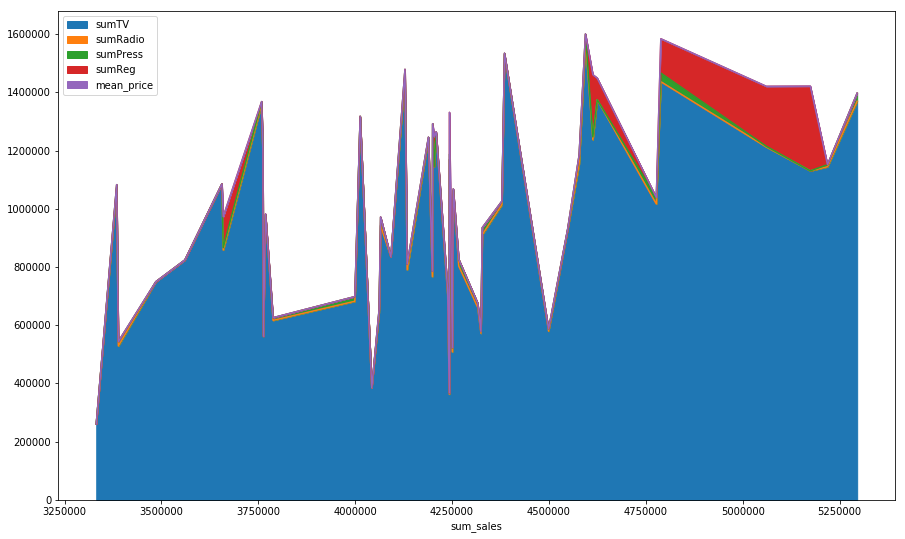

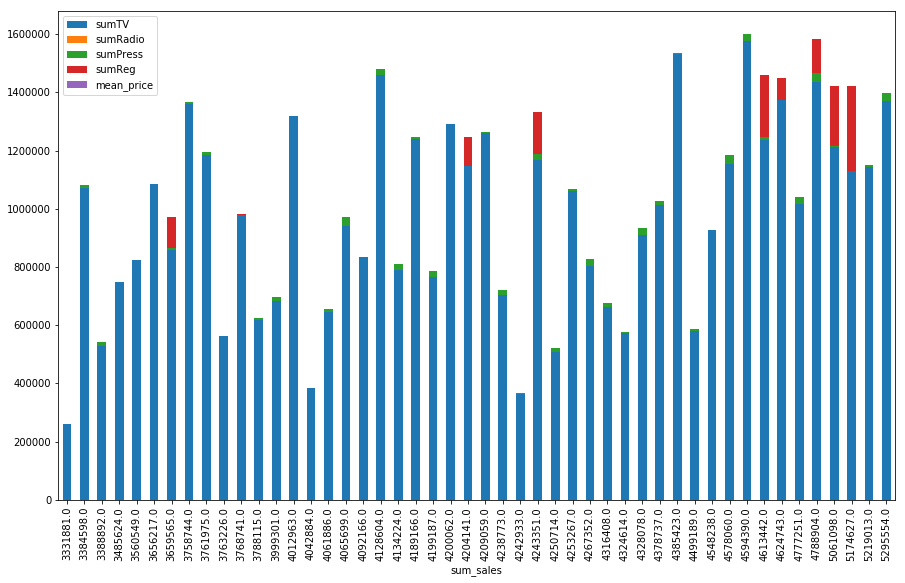

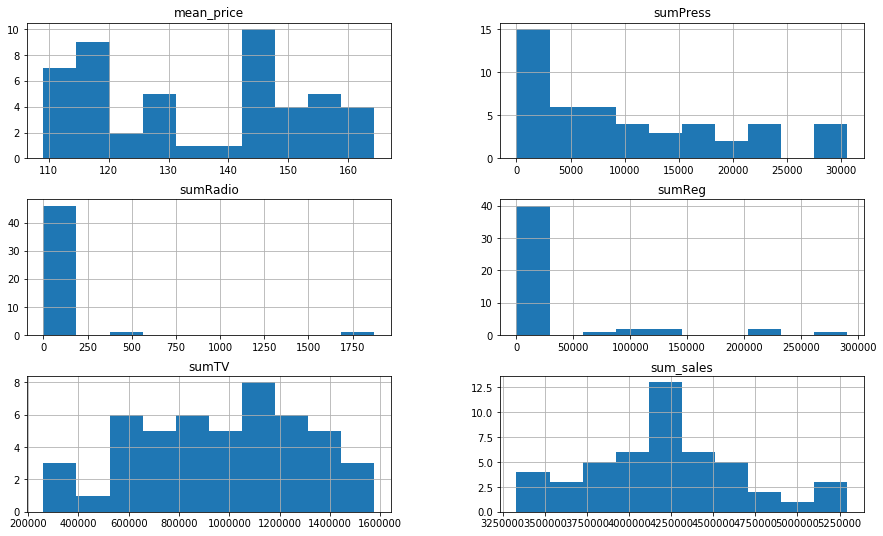

In [7]:
'''Тут делаю тоже самое, но для суммы всех брэндов этой категории. 
Очевидно, что в случае с другими брэндами, куда большее значение играет реклама на региональном ТВ.'''

sumTV = media_data.loc[:, 'TV.brand_X' : 'TV.brand_10'].sum(axis = 1)
sumRadio = media_data.loc[:, 'Radio.brand_X' : 'Radio.brand_9'].sum(axis = 1)
sumPress = media_data.loc[:, 'Press.brand_X' : 'Press.brand_10'].sum(axis = 1)
sumReg = media_data.loc[:, 'Reg.TV.brand_X' : 'Reg.TV.brand_10'].sum(axis = 1)

df_sum = pd.DataFrame(np.array([sumTV, sumRadio, sumPress, sumReg], ndmin=2).T, columns = ['sumTV', 'sumRadio', 'sumPress', 'sumReg'])

df_sum.insert(loc = 4, column = 'mean_price', value = np.array(sales_data[24:]['Price WholeMarket']))
df_sum.insert(loc = 5, column = 'sum_sales', value = np.array(sales_data[24:]['WholeMarket']))

df_sum.sort_values('sum_sales').set_index('sum_sales').plot.area(stacked=True) #hist(stacked=True, bins=2)
df_sum.sort_values('sum_sales').set_index('sum_sales').plot.bar(stacked=True)

df_sum.hist()


In [4]:
'''Описываю функции для модификации выборки. Делаю допущение, что для всех типов рекламы имеем
одинаковые коэффициенты преобразования (т.е. восстанавливаю 4 коэффициента). 
Пробовал подбирать различные коэффициенты для разных признаков - ничего путного из этого не вышло.
Больше всего проблем было именно с этой частью. По хорошему, коэффициенты должны быть разные 
для разных типов рекламы, при этом коэф. b (в знаменателе) - это и есть вес каждого признака. 
И, навешивая на него ограничения, по идее, мы получаем ту же регрессию с регуляризацией.
По факту таким образом ничего не выходит. То ли чего-то не понимаю, то ли не так делаю...'''

def delay(exp_scale, media_data):     
    
    time_int = len(media_data)
        
    k = 0     
    
    delayed_ad = np.zeros(media_data.shape)  
     
    for field in media_data.columns: 
        for i in range(time_int):
            for j in range(i, time_int):
                delayed_ad[j, k] += media_data[field][i] * np.exp(exp_scale*(i-j))
        k += 1
        
    return delayed_ad
    
    
def response(coef, media_data):
               
    effective_ad = delay(coef[0], media_data)
           
    num_mod = media_data.shape[1]
    
    if len(coef) == 4: 
                        
        for k in range(num_mod):
            a = coef[1]
            b = coef[2]
            s = coef[3]
            effective_ad[effective_ad[:,k] > 0, k] = a/(b + effective_ad[effective_ad[:,k] > 0, k]**(-s))                              
            
    elif len(coef) == 3:
        
        for k in range(num_mod):
            b = coef[1]
            s = coef[2]
            effective_ad[effective_ad[:,k] > 0, k] = 1/(b + effective_ad[effective_ad[:,k] > 0, k]**(-s))        
    
    else: 
        print('Error in response function!!! There are only possibilities to provide 3 or 4 \
        coefficients to modify!')        
        return None 
    
    return effective_ad
                
  
'''Задаю функцию невязки, которую буду минимизировать. По идее, невязку нужно нормировать, 
чтобы вклад от всех значений был одинаковый (второая фунция residual), но в мануалах прямо об этом ничего не пишут, 
поэтому пробую оба варианта.'''

def difference(coef, media_data, sales_data, vector=True): 
    
    num_mod = media_data.shape[1]
    
    effective_ad = response(coef, media_data)
    
    difference = (np.array(sales_data, ndmin=2).T - np.sum(effective_ad, axis=1, keepdims=2))
    
    if vector:
        return difference.flatten()
    else:
        return norm(difference.flatten())

def residual(coef, media_data, sales_data, vector=True): 
    
    effective_ad = response(coef, media_data)
    
    residual = (np.array(sales_data, ndmin=2).T - np.sum(effective_ad, axis=1, keepdims=2))/np.array(sales_data, ndmin=2).T
    
    if vector:
        return residual.flatten()
    else:
        return norm(residual.flatten())
    

'''Пытаюсь навешать на эти функции какую-то регуляризацию. Намного хуже от этого не стало, но и лучше тоже.
Может быть из этого и можно было что-то вытянуть, но это сомнительно, и я и так убил на эту часть слишком много времени.'''
    
# def diff_reg(coef, media_data, sales_data, alpha = 1): 
    
#     num_mod = media_data.shape[1]
           
#     if len(coef)/num_mod == 4:
#         effective_ad, w = response(coef, media_data)
#     else:
#         print('Error!!! diff_reg function needs 4 coefficients and calculated weight vector w to minimize!')
      
#     difference = (np.array(sales_data, ndmin=2).T - np.sum(effective_ad, axis=1, keepdims=2))
    
#     return np.append(difference.flatten(), alpha*w)

# def res_reg(coef, media_data, sales_data, alpha = 1):
    
#     num_mod = media_data.shape[1]
    
#     if len(coef)/num_mod == 4:
#         effective_ad, w = response(coef, media_data)
#     else:
#         print('Error!!! res_reg function needs 4 coefficients and calculated weight vector w to minimize!')
      
#     residual = (np.array(sales_data, ndmin=2).T - np.sum(effective_ad, axis=1, keepdims=2))
    
#     return np.append(residual.flatten(), alpha*w)

In [5]:
'''Далее начинаю подгонку коэффициентов преобразования выборки. Использую метод наименьших квадратов. 
Начальные значения коэффициентов я подбирал из вида графиков и соотношения ln(y)/ln(x).
Вариант с 3 коэффициентами пробовал из описанного выше соображения, 
что если коэффициент b в знаменателе - это вес каждого признака, то на этом этапе его можно не подгонять, 
т.к. потом это будет делаться каким-нибудь стандартным методом из sklearn.
Кроме того, тут я проверяю линейный и нелинейный МНК (leastsq и least_squares) - опять же для провернки.
По идее, достаточно и линейного, но там нельзя указать ограничения на параметры.
На самом деле я тут пробовал намного больше различных функций и комбинаций, потому что всё как-то неочевидно.
Параметров 4, функции нелинейные, зависит от этого тоже много. 
В том числе пытался подбирать коэффициенты для модернизации данных, описывающих другие брэнды. 
Но вот из этого совсем ничего не вышло.
В итоге оставил только эту часть, в основном просто для демонстрации того, куда потратил столько времени :) '''

from scipy import optimize

# 3 coefficients are used for optimization
coef3 = [0.1, 1e-7, 0.84]

# 4 coefficients are used for optimization
coef4 = [0.1, 1, 1e-7, 0.84]

used_columns = ['TV.brand_X', 'Radio.brand_X', 'Press.brand_X', 'Reg.TV.brand_X']

X = df_brandX[used_columns]
y = df_brandX['sales brand_X']

X_sum = df_sum.loc[:,'sumTV':'sumReg']
y_sum = df_sum['sum_sales']

df_optcoef = pd.DataFrame()
df_r2 = pd.DataFrame()

for X_used, y_used in [(X, y)]:
    
    tmp_coef = {}
    tmp_r2 = {}

    if(y_used.name == 'sales brand_X'):
        tmp_coef['Data'] = 'brand_X'
        tmp_r2['Data'] = 'brand_X'
    elif(y_used.name == 'sum_sales'):
        tmp_coef['Data'] = 'sum'
        tmp_r2['Data'] = 'sum'
    else:
        tmp_coef['Data'] = 'undefined'
        tmp_r2['Data'] = 'undefined'

    for fun in [difference, residual]:  
        
        tmp_coef['Model'] = fun.__name__
        tmp_r2['Model'] = fun.__name__
    
        for x0 in [coef3, coef4]:        
            
            tmp_coef['x0'] = len(x0)
            tmp_r2['x0'] = len(x0)
               
            lsq_nonlin = scipy.optimize.least_squares(fun, x0, loss='linear', args=(X_used, y_used), ftol=1e-03, xtol=1e-03, bounds = (0, np.inf))
            lsq_lin = scipy.optimize.leastsq(fun, x0, args=(X_used, y_used),ftol=1e-03, xtol=1e-03, full_output=1)
#             if len(x0) == 3:
#                 slsqp = scipy.optimize.minimize(fun, x0, args=(X_used, y_used, False), method='SLSQP', bounds = ((0, None),(0, None),(0, None)))            
#             elif len(x0) == 4:
#                 slsqp = scipy.optimize.minimize(fun, x0, args=(X_used, y_used, False), method='SLSQP', bounds = ((0, None),(0, None),(0, None),(0, None)))
            
            if len(x0) == 3:
                coef_nonlin = np.insert(lsq_nonlin.x, 1, 1)
                coef_lin = np.insert(lsq_lin[0], 1, 1)    
#                 coef_slsqp = np.insert(slsqp.x, 1, 1) 
            elif len(x0) == 4:
                coef_nonlin = lsq_nonlin.x          
                coef_lin = lsq_lin[0]
#                 coef_slsqp = slsqp.x 
            
            tmp_coef['lin'] = coef_lin
            tmp_coef['nonlin'] = coef_nonlin
            #tmp_coef['slsqp'] = coef_slsqp
            
            # Качество подгонки оцениваю с помощью R2:        
            effective_ad = response(coef_lin, X_used)
            tmp_r2['lin'] = r2_score(y_used, np.sum(effective_ad, axis=1))
        
            effective_ad = response(coef_nonlin, X_used)
            tmp_r2['nonlin'] = r2_score(y_used, np.sum(effective_ad, axis=1))
            
#             effective_ad = response(coef_slsqp, X_used)
#             tmp_r2['slsqp'] = r2_score(y_used, np.sum(effective_ad, axis=1))
                
            df_optcoef = df_optcoef.append([tmp_coef], ignore_index=True)
            df_r2 = df_r2.append([tmp_r2], ignore_index=True) 
            
    

In [742]:
'''Тут оцинваю получившийся результат. Как уже говорил, теоретически мне больше нравится вариант с 3 коэффициентами,
но вариант с 4 всё же намного лучше, в том числе эти коэффициенты дают лучшие результаты на кросс-валидации в дальнейшем
при построении модели регрессии.'''
df_r2

,Data,Model,lin,nonlin,x0
0,brand_X,difference,0.641618,0.641614,3
1,brand_X,difference,0.680142,0.673951,4
2,brand_X,residual,0.613929,0.613954,3
3,brand_X,residual,0.650559,0.633133,4


In [743]:
'''Тут смотрю сами коэффициенты, в первую очередь на предмет отрицательных.'''
for i in range(4):
    print('i = ',i,' : ', df_optcoef.loc[i,'lin'])
    print('i = ',i,' : ', df_optcoef.loc[i,'nonlin'])
    print('-------------------')


i =  0  :  [  2.01537905e-01   1.00000000e+00   4.73711255e-06   9.29303436e-01]
i =  0  :  [  2.02291484e-01   1.00000000e+00   4.74147980e-06   9.29603643e-01]
-------------------
i =  1  :  [  2.62778820e-01   1.80391663e+02   1.61920418e-04   4.90898941e-01]
i =  1  :  [  2.45920874e-01   6.50245884e+01   1.44786484e-04   5.81171575e-01]
-------------------
i =  2  :  [  1.94247104e-01   1.00000000e+00   5.06189938e-06   9.26801283e-01]
i =  2  :  [  1.94898662e-01   1.00000000e+00   5.06472003e-06   9.27028005e-01]
-------------------
i =  3  :  [  2.30257578e-01   4.66957766e+01   1.23722365e-04   6.05419967e-01]
i =  3  :  [  2.10662600e-01   7.83089036e+00   3.19222187e-05   7.57118679e-01]
-------------------


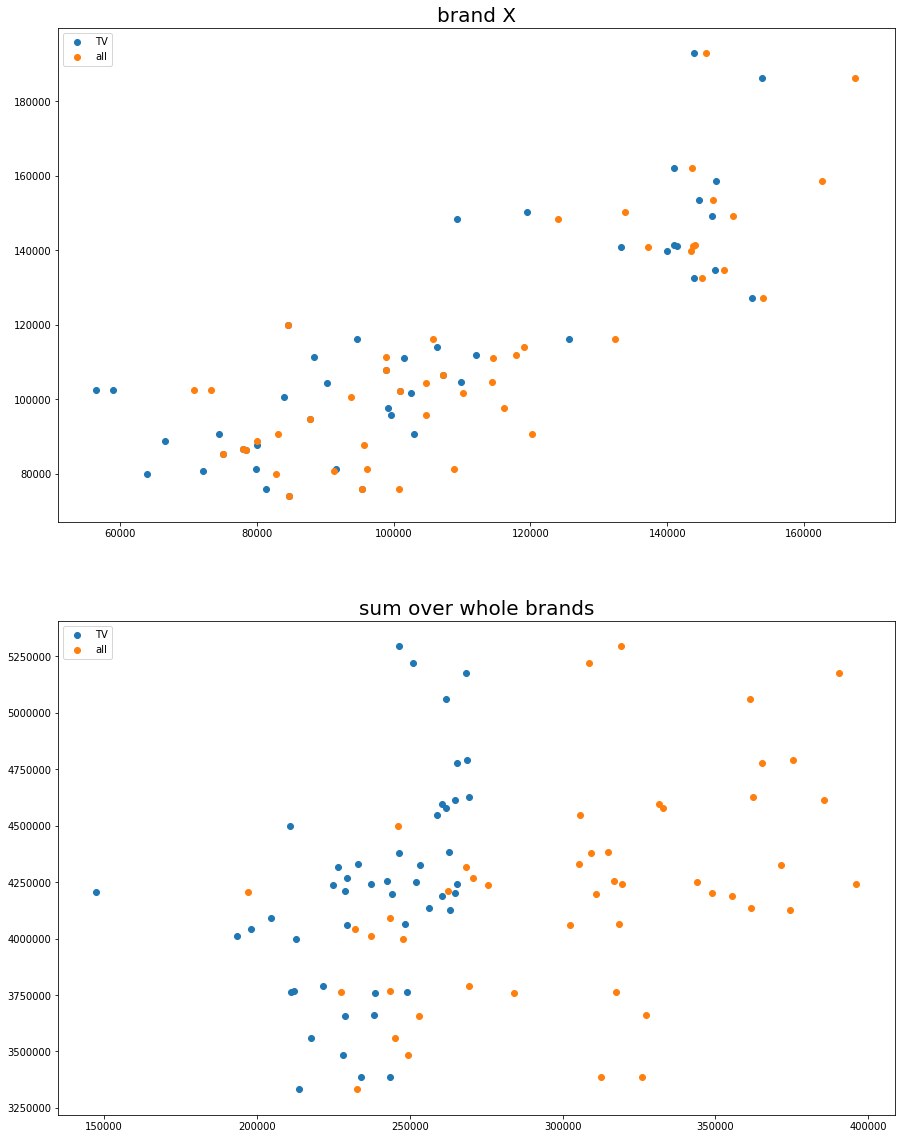

In [772]:
'''Смотрю, как это всё выглядит. Очевидно, для суммы всех брендов категории этот метод преобразования не годится.
Как говорил выше, пытался подбирать коэффициенты для суммы по категориями, и для каждого бренда отдельно, а потом 
суммировать. Если и было немного лучше, то незначительно. А главное, я не придумал как это можно дальше использовать.
Была идея, что можно на этих данных строить модель, а валидацию делать на данных для брэнда Х, или наоборот, или 
строить модель на всех данных одновременно, или на данных для бренда Х и сумме по категорим для всех брэндов. 
Всё попробовал и ничего не получилось. Возможно, не докрутил или неправильно пробовал...'''

fin_coef_X = df_optcoef.loc[1,'lin']

effective_ad = response(fin_coef_X, X)
df_effX = pd.DataFrame(effective_ad, columns = ['tv', 'radio', 'press', 'reg'])
df_effX['price'] = df_brandX['Price brand_X']
df_effX['sales'] = df_brandX['sales brand_X']


fin_coef_sum = df_optcoef.loc[1,'lin']
X_sum = df_sum.loc[:,'sumTV':'sumReg']

effective_sum_ad = response(fin_coef_sum, X_sum)
df_eff_sum = pd.DataFrame(effective_sum_ad, columns = ['sumTV', 'sumRadio', 'sumPress', 'sumReg'])
df_eff_sum['mean_price'] = df_sum['mean_price']
df_eff_sum['sum_sales'] = df_sum['sum_sales']

#plt.bar(x=np.sum(effective_ad, axis=1), y = y_used)
fig, ax = plt.subplots(2,1, figsize=(15,20))
ax[0].scatter(x = df_effX['tv'], y = df_effX['sales'], label='TV')
ax[0].scatter(x = np.sum(df_effX.loc[:,'tv':'reg'],axis=1), y = df_effX['sales'], label='all')
ax[0].set_title('brand X', fontsize=20)
ax[0].legend(loc=2)

ax[1].scatter(x = df_eff_sum['sumTV'], y = df_eff_sum['sum_sales'], label='TV')
ax[1].scatter(x = np.sum(df_eff_sum.loc[:,'sumTV':'sumReg'],axis=1), y = df_eff_sum['sum_sales'], label='all')
ax[1].set_title('sum over whole brands', fontsize=20)
ax[1].legend(loc=2)

# ax[2].scatter(x = df_sum['sumTV'], y = df_sum['sum_sales'], label='TV')
# ax[2].scatter(x = np.sum(df_sum.loc[:,'sumTV':'sumReg'],axis=1), y = df_sum['sum_sales'], label='all')
# ax[2].set_title('mean over whole brands', fontsize=20)
# ax[2].legend(loc=2)


In [827]:
'''Здесь пробую разные методы и выбираю тот, который буду использовать.'''

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn import model_selection
from sklearn.decomposition import PCA

models = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), 
          KNeighborsRegressor(), SVR(), LogisticRegression(), Ridge(), Lasso()]

cv_kfold = model_selection.KFold(n_splits = 4, shuffle = True, random_state=42)

TestModels = pd.DataFrame()
tmp = {}

# В том числе использую цену как параметр. С ней получается немного лучше
X_train = df_effX.loc[:,'tv':'price']
y_train = df_effX['sales']

X_sum = df_eff_sum.loc[:,'sumTV':'mean_price']

# y_train = df_eff_sum['sum_sales']

# X_train = df_sum.loc[:,'sumTV':'mean_price']
# y_train = df_sum['sum_sales']


# pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X_train)
# print('var = ', pca.explained_variance_ratio_)
# print('SV = ', pca.singular_values_)

#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    tmp['Model'] = m[:m.index('(')]   
    
    # Использую кросс-валидацию:
    score_r2 = model_selection.cross_val_score(estimator=model, X = X_train, y = y_train, cv = cv_kfold, scoring='r2')
    
    # Оцениваю опять же по R2
    tmp['R2'] = score_r2.mean()
    
    TestModels = TestModels.append([tmp])

TestModels.set_index('Model', inplace=True)

'''Многие методы дают примерно одинаковые результаты. 
Очевидно, какой-то из них может выйграть при настройке параметров'''

TestModels

,R2
Model,
LinearRegression,0.439049
RandomForestRegressor,0.406234
GradientBoostingRegressor,0.480016
KNeighborsRegressor,0.514148
SVR,-0.097456
LogisticRegression,0.517353
Ridge,0.439285
Lasso,0.439056


In [863]:
'''Тут проверяю разные методы с разными параметрами. Считается это всё довольно долго.'''

df_gridSearch = pd.DataFrame()

gb_param = {'loss':['ls', 'lad'], 'n_estimators':np.power(10, np.arange(2, 5))}
log_param = {'penalty':['l1', 'l2'], 'C':np.power(10.0, np.arange(-3, 5))}
lasso_param = {'alpha':np.power(10.0, np.arange(-2, 6))}
rf_param = {'n_estimators':np.power(10,np.arange(1,5))}
knb_param = {'n_neighbors':range(5,21), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p':[1,2,3], 'leaf_size': range(10,100, 5)}

gs_gb = model_selection.GridSearchCV(GradientBoostingRegressor(), gb_param, scoring='r2', cv=cv_kfold)
gs_gb.fit(X_train, y_train)
df_gridSearch = df_gridSearch.append([{'Model': 'GB', 'best_score': gs_gb.best_score_, 'best params': gs_gb.best_params_}])

gs_lasso = model_selection.GridSearchCV(Lasso(), lasso_param, scoring='r2', cv=cv_kfold)
gs_lasso.fit(X_train, y_train)
df_gridSearch = df_gridSearch.append([{'Model': 'Lasso', 'best_score': gs_lasso.best_score_, 'best params': gs_lasso.best_params_}])

gs_log = model_selection.GridSearchCV(LogisticRegression(), log_param, scoring='r2', cv=cv_kfold)
gs_log.fit(X_train, y_train)
df_gridSearch = df_gridSearch.append([{'Model': 'Log', 'best_score': gs_log.best_score_, 'best params': gs_log.best_params_}])

gs_rf = model_selection.GridSearchCV(RandomForestRegressor(), rf_param, scoring='r2', cv=cv_kfold)
gs_rf.fit(X_train, y_train)
df_gridSearch = df_gridSearch.append([{'Model': 'RF', 'best_score': gs_rf.best_score_, 'best params': gs_rf.best_params_}])

gs_knb = model_selection.GridSearchCV(KNeighborsRegressor(), knb_param, scoring='r2', cv=cv_kfold)
gs_knb.fit(X_train, y_train)
df_gridSearch = df_gridSearch.append([{'Model': 'kNB', 'best_score': gs_knb.best_score_, 'best params': gs_knb.best_params_}])

# print('GB best score: ', gs_GB.best_score_, '\t Lasso best score: ', gs_lasso.best_score_, \
#       '\t RF best score: ', gs_rf.best_score_, '\t Log best score: ', gs_log.best_score_, \
#      '\t KNB best_score: ', gs_knb.best_score_)
# print('GB best params: ', gs_GB.best_params_, '\nLasso best params: ', gs_lasso.best_params_,\
#       '\nRF best params: ', gs_rf.best_params_, '\nRF best params: ', gs_rf.best_params_,)
df_gridSearch

,Model,best params,best_score
0,GB,"{'loss': 'lad', 'n_estimators': 100}",0.641981
0,Lasso,{'alpha': 100000.0},0.589660
0,Log,"{'C': 10000.0, 'penalty': 'l1'}",0.532703
0,RF,{'n_estimators': 100},0.498655
0,kNB,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",0.633187


In [877]:
'''Победил Gb. Тут делаю его более тонкую настройку. Вообще получася по-разному при разных запусках.
Иногда получалось доганять качество до 0.7, но в последний раз почему-то нет.'''

GB_param_V2 = {'loss':['lad'], 'n_estimators':np.arange(100, 500, 50)}
#log_param_V2 = {'penalty':['l1'], 'C':np.arange(0.1, 10, 0.1)}

gs_GB_V2 = model_selection.GridSearchCV(GB, GB_param_V2, scoring='r2', cv=cv_kfold)
gs_GB_V2.fit(X_train, y_train)

# gs_log_V2 = model_selection.GridSearchCV(LogisticRegression(), log_param_V2, scoring='r2', cv=cv_kfold)
# gs_log_V2.fit(X_train, y_train)

print('GB best score: ', gs_GB_V2.best_score_)#, '\t LogReg best score: ', gs_log_V2.best_score_)
print('GB best params: ', gs_GB_V2.best_params_)#, '\nLogReg best params: ', gs_log_V2.best_params_)ex('Model').loc['GB', 'best params']

GB best score:  0.648444692476
GB best params:  {'loss': 'lad', 'n_estimators': 350}


In [878]:
'''Обучаю выбранную модель. Кросс-валидация из предыдушего блока всегда даёт разные количества n_estimators.
Видимо потому, что мало данных. Но вроде как в ГБ чем больше это количество, тем, как правило, лучше, поэтому
всё же возьму побльше. Тем более с такой моделью в последующем получается лучше результат при оптимизации продаж на 2017'''

clf_gb = GradientBoostingRegressor(loss='lad', n_estimators=400, random_state=42)
clf_gb.fit(X_train, y_train)

# clf_log = LogisticRegression(C=0.1, random_state=42)
# clf_log.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

feature importances:  [ 0.42680929  0.01300363  0.16559518  0.11105193  0.28353997]


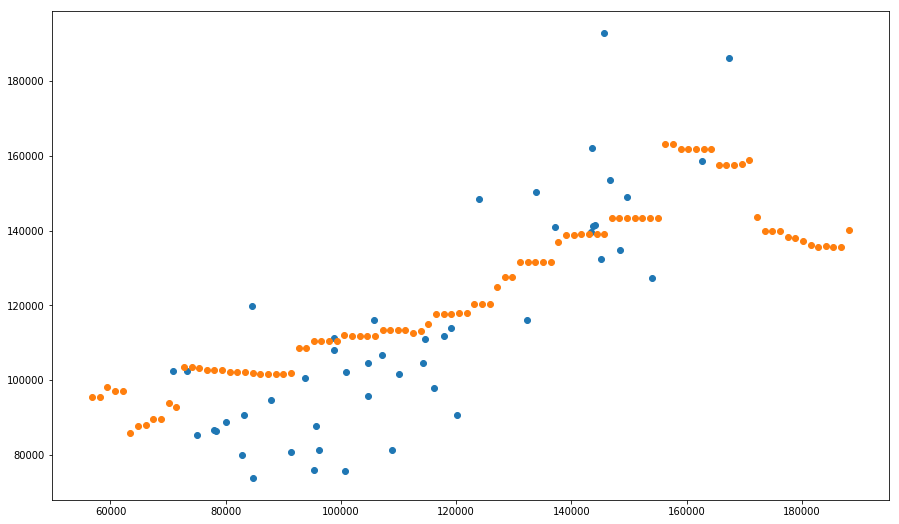

In [879]:
'''Cмотрю что получичлось'''

print('feature importances: ', clf_gb.feature_importances_)

#plt.scatter(np.sum(X_train, )
plt.scatter(x = np.sum(df_effX.loc[:,'tv':'reg'], axis=1), y = df_effX['sales'], label='all')
#x_mod = np.linspace(np.sum(df_effX.loc[:,'tv':'reg'],axis=1).min(), np.sum(df_effX.loc[:,'tv':'reg'],axis=1).max, 100)
#plt.scatter(x = )
#np.linspace(np.min(np.sum(df_effX.loc[:,'tv':'reg'],axis=1)), np.max(np.sum(df_effX.loc[:,'tv':'reg'],axis=1)), 100)
x_mod = np.zeros([100, 5])
x_mod[:,0] = np.linspace(df_effX['tv'].min(), df_effX['tv'].max(), 100)
x_mod[:,1] = np.linspace(df_effX['radio'].min(), df_effX['radio'].max(), 100)
x_mod[:,2] = np.linspace(df_effX['press'].min(), df_effX['press'].max(), 100)
x_mod[:,3] = np.linspace(df_effX['reg'].min(), df_effX['reg'].max(), 100)
x_mod[:,4] = np.linspace(df_effX['price'].mean(), df_effX['price'].mean(), 100)

y_mod = clf_gb.predict(x_mod)
plt.scatter(x = np.sum(x_mod, axis=1), y = y_mod, label='model')


In [868]:
'''Тут задаю функции для оптимизации рекламы. Использую функцию minimize из scipy с SLSQP. 
Тут тоже были проблемы, потому что функция какая-то сранная и постоянно выдает разные результаты. 
При этом вначале вообще вылетала с неясными объясненениями, потом вроде заработало, но часто ограничивается одной 
операцией в зависимости от ограничений, якобиана и прочего. Долго с ней возился, постарался выбрать лучший вариант
из того, что получалось. Но совсем не уверен в том, что это вообще верно.'''

def optimal_sales(ad_coef, price, clf):
    
    # Моделирую рекламу на 2017 год с учетом условия: 
    # 1) медиаактивность должна быть одинаковой каждый месяц
    # 2) цена будет такой же, как в 2016
    ad = np.tile(ad_coef, [12,1])
    eff_ad = response(fin_coef_X, pd.DataFrame(ad))

    X = np.insert(eff_ad, 4, price, axis=1)
    sales = clf.predict(X)
        
    # Jacobian calculation:    
    #delay_ad = delay(fin_coef_X[0], pd.DataFrame(ad))        
    #jac = (1/fin_coef_X[1])*eff_ad**2*fin_coef_X[0]*delay_ad**(-fin_coef_X[3]-1)*delay(fin_coef_X[0], pd.DataFrame(np.ones(eff_ad.shape)))            
    #jac = -10*clf.feature_importances_[:4]
        
    return (-np.sum(sales)) #, jac, [-100, -10, -10, -10]


'''Тут задаю ограничение на максимальный бюджет'''
def budget_max(ad_coef):
    
    budget = 0.16*ad_coef[0] + 0.075*ad_coef[1] + 0.6*ad_coef[2] + 0.1*ad_coef[3]
    
    return (100e6 - budget)


'''Тут задаю такое же ограничение на минимальный бюджет, ибо иначе оно может выдать слишком маленькое значение,
что сомнительно'''
def budget_min(ad_coef):
    
    budget = 0.16*ad_coef[0] + 0.075*ad_coef[1] + 0.6*ad_coef[2] + 0.1*ad_coef[3]
    
    return (budget - 50e6)

''''''
def budget_max_jac(x):
    
    jac = np.zeros(4)
    jac[0] = -0.16
    jac[1] = -0.075
    jac[2] = -0.6
    jac[3] = -0.1
    return jac

def budget_min_jac(x):
    
    jac = np.zeros(4)
    jac[0] = 0.16
    jac[1] = 0.075
    jac[2] = 0.6
    jac[3] = 0.1
    return jac

In [880]:
'''Оптимизирую месячное количество рекламы разного типа'''

price_2016 = sales_data.set_index('Year')['Price brand_X'][2016]

x0 = [1, 1, 1, 1]

# x0[0] = df_brandX.loc[df_brandX['sales brand_X'].argmax(), 'TV.brand_X']
# x0[1] = df_brandX.loc[df_brandX['sales brand_X'].argmax(), 'Radio.brand_X']
# x0[2] = df_brandX.loc[df_brandX['sales brand_X'].argmax(), 'Press.brand_X']
# x0[3] = df_brandX.loc[df_brandX['sales brand_X'].argmax(), 'Reg.TV.brand_X']

bnds = ((0, None),(0, None),(0, None),(0, None))
cons = ({'type': 'ineq', 'fun': budget_max, 'jac': budget_max_jac}, {'type': 'ineq', 'fun': budget_min, 'jac': budget_min_jac}) 

opt_ad_2017 = scipy.optimize.minimize(fun=optimal_sales, x0=x0, args=(price_2016, clf_gb), jac=False, method='SLSQP', options={'disp': True, 'maxiter':10e5, 'eps': 10e6}, constraints=cons, bounds=bnds)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2118680.9962964775
            Iterations: 6
            Function evaluations: 67
            Gradient evaluations: 6


In [859]:
'''Результаты. Третий парметр отвечает за рекламу в прессе и получается нулевым'''
opt_ad_2017

     fun: -2118680.9962964775
     jac: array([ 0.        ,  0.        ,  0.04251272,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([  2.71889559e+08,   1.07280791e+07,   9.71698798e-13,
         5.69306458e+07])

In [860]:
'''От бюджета остается половина, но при этом количество рекламы, в частности, по ТВ получается
больше чем в 100 раз больше, чем в модельной выборке. Всё же очень сомнительная процедура, и результаты...'''

budget_max(opt_ad_2017.x)

49999999.999999985

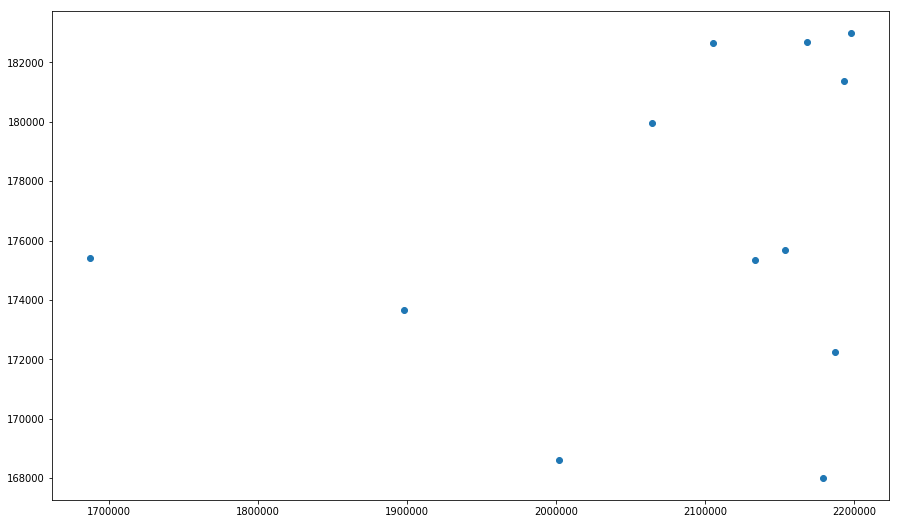

In [851]:
'''Предсказания модели для такой выборки на графике тоже выглядят не очень. 
Хотя трудно сказать, должно ли оно при таких условиях выглядеть красиво.'''

def opt_sales_2017(ad_coef, price, clf):
    
    # Моделирую рекламу на 2017 год с учетом условия: 
    # 1) медиаактивность должна быть одинаковой каждый месяц
    # 2) цена будет такой же, как в 2016
    ad = np.tile(ad_coef, [12,1])
    eff_ad = response(fin_coef_X, pd.DataFrame(ad))

    X = np.insert(eff_ad, 4, price, axis=1)
    sales = clf.predict(X)       
       
    return sales, eff_ad

sales_2017, ad_2017 = opt_sales_2017(opt_ad_2017.x, price_2016, clf_gb)

plt.scatter(np.sum(ad_2017, axis=1), sales_2017)